### Introduction: 

You have now created your own App, integrated data, and engineered Features and stored Features in the Feature Store, and trained an MlPipeline to predict high Gear Oil Temp for `TURBINE-1`

### Assignment: 
During the model deployment phase of the workshop, you will deploy the trained `MlPipeline` from the previous exercise to make predictions for `TURBINE-1` and automatically store predictions in the `WindTurbinePrediction` Type

### Before You Start: 

In this notebook you will find...
* Cells with a "blue" banner and the keyword "Exercise", these provide specific instructions on what needs to be done. 
* Blank cells with "TODO" comments. Your goal is to fill in these cells with the necessary code. Try doing this on your own, but if you need help, you can ask a C3 AI team member or refer to the _Solutions_ notebook located in the same folder
* You can press TAB for auto-completion, and SHIFT+TAB to reveal both the signature of a function and additional documentation. You can also directly access documentation for any C3 Type by using the `help()` function.
* If you get stuck, you can take a look at the tutorial notebooks for hints or reach out to one of the C3 AI team member. 

## Model Deployment Overview

When our Application requests predictions for `TURBINE-1` we want the predictions to be generated from the `MlPipeline` we just trained, and automatically store predictions in a database so that our Applicaiton can query them.

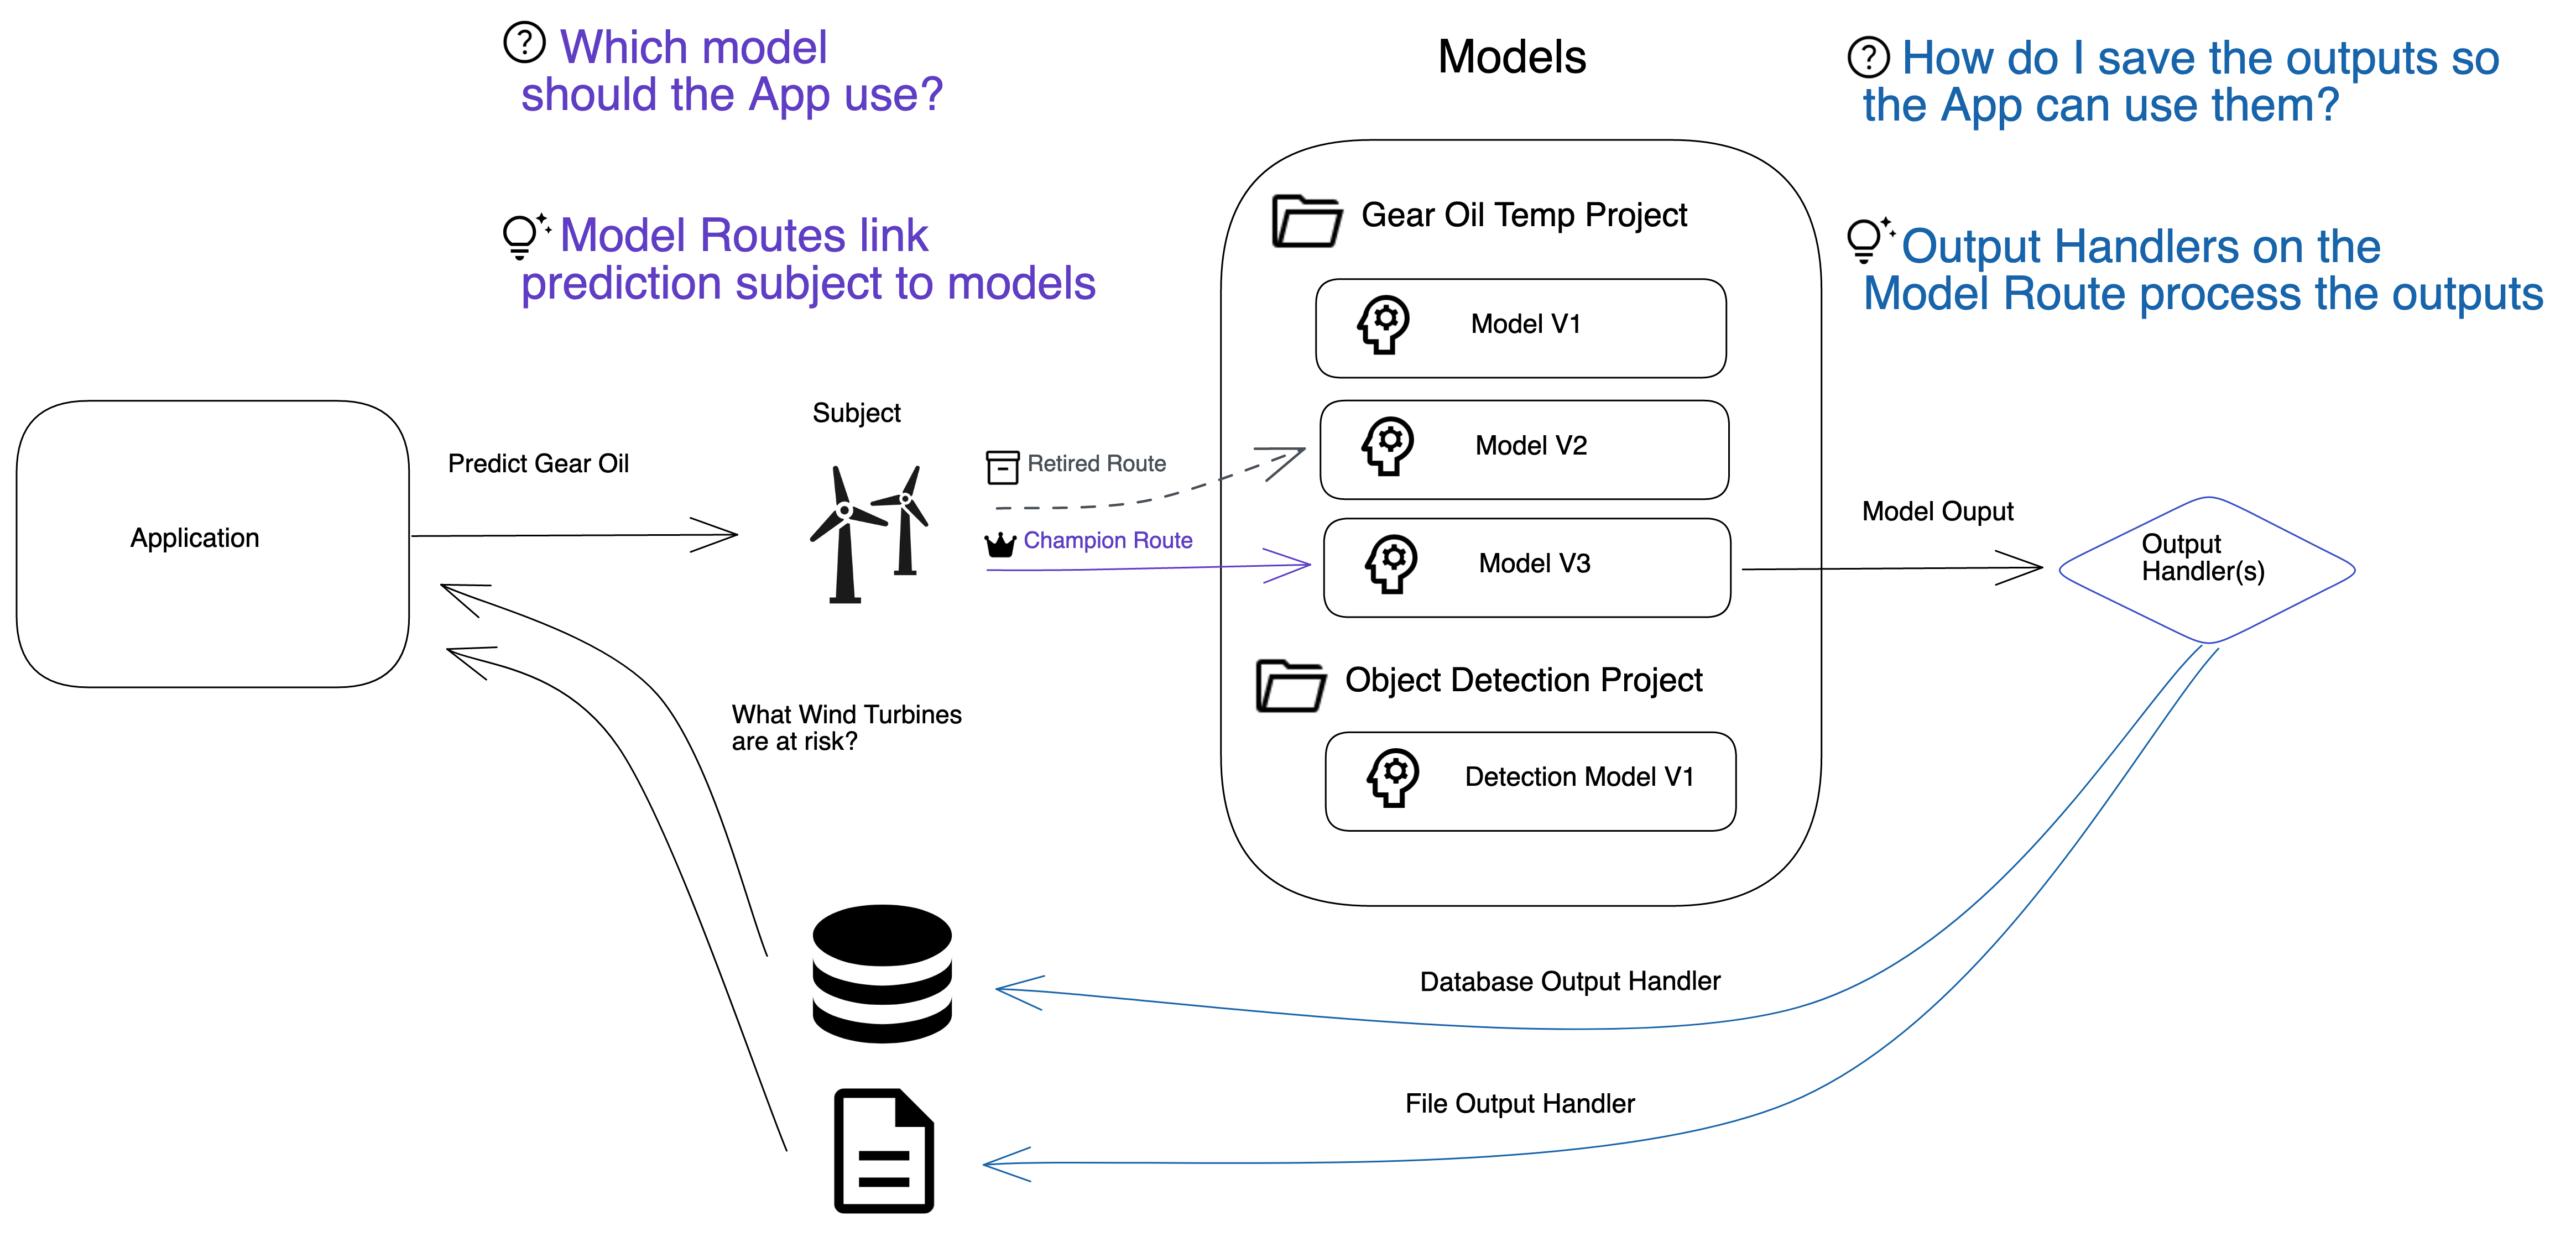

### Why do we need the Model Deployment Framework?

The Model Deployment Framework helps Data Scientists and Application Developers train, deploy, and manage the life cycle of machine learning models. It also handles the
management of prediction routing and persistence.

Model Deployment enables the flexible configuration of both simple single-model deployments (e.g. one model serving all predictions) and complex multi-model deployments.
This enables Data Scientists and Application Developers to:
- serve models for predictions.
- handle the life cycle of models: deployment, retraining, retiring.
- route requests of predictions to the correct model.
- persist predictions in a consistent way to ensure traceability.

### Key Types and Concepts

Model Deployment provides a few types that you should know about:
* `MlProject`: the machine learning project that addresses a single application use case. The project defines a consistent "input" and "output" interface for Applications to develop against. The "input" is an `MlSubject` (more on this below) and the "output" is a C3 Type where predictions will be persisted to. In other words, it is the "contract" between Data Scientist and Application Developer and thus is central to the API flows in MDF.
* `MlSubject`: the individual asset (e.g. sensor, etc) which is associated as the data source or "input" to an `MlProject`. Colloquially, this type represents the "subject" of the predictions within the project.
* `MlPipeline`: a machine learning flow, represented by a directed acyclic graph, authored by a Data Scientist - this captures all of the steps in the flow, including library dependencies, model architectures, data dependencies, and how to execute common operations such as training, scoring, and prediction.
* `MlModel`: a self-operable machine learning model. In particular, an `MlModel` is able to train and make predictions without the user providing data. It combines the ML execution knowledge of the `MlPipeline` with the data retrieval knowledge of `Feature.Set`. This will be demonstrated in the API examples below.

### Create an `MlProject`

In [1]:
project = c3.MlProject(
    id="tutorial-predictive-maintenance",
    name="Predictive Maintenance",
    subjectType=c3.WindTurbine,
    router=c3.MlModel.RuleRouter().create(),
    targetTypes = [c3.WindTurbinePrediction]
).merge(spec=dict(returnInclude="this"))

### Create a Model

First, we need to assign `Feature.Set`(s) to the `MlPipeline` so that we know what features to use when creating predictions

<div class="alert-warning">
    <b>Pre-requisites</b>: 
    <ol>
    <li> You have created two `Feature.Set`s during the Feature Engineering workshop. </li>
    <li> You have created an `MlPipeline` during the Model Development workshop. </li>
    <ol>
    
</div>

<div class="alert-info">
    <b>Exercise</b>: Create an `MlModel` than links our `Feature.Set` to `MlPipeline` for the `MlProject` we just created
    <br>
    <br>
    <div><i>Hint</i>: Get the `Feature.Set` and `MlPipeline` by id, and use in the MlModel constructor.
    </div>
    <br>
</div>

In [3]:
# # TODO: Create an MlModel using the previously created Feature.Set and MlPipeline

# # You may need to update the id's if you used different id's
# trained_pipeline=c3.MlPipeline.forId("turbine1-gearoiltemp-class-pipeline")
# X_feature_set = c3.Feature.Set.forId("WindTurbine#windTurbineFeatures_ml")
# y_feature_set = c3.Feature.Set.forId("WindTurbine#labelFeatureSet")

# model = c3.MlModel(
#     id="tutorial-simple-model-v1",
#     pipeline=##TODO,
#     project=project,
#     xFeatures={'features': ##TODO},
#     yFeatures={'failureLabel': ##TODO},
# ).create()

### Deploy the `MlModel` to make predictions for `TURBINE-1`

In [4]:
route = model.deploy(subjectFilter = "id == 'TURBINE-1'")

Or Deploy from AI Studio Model Ops

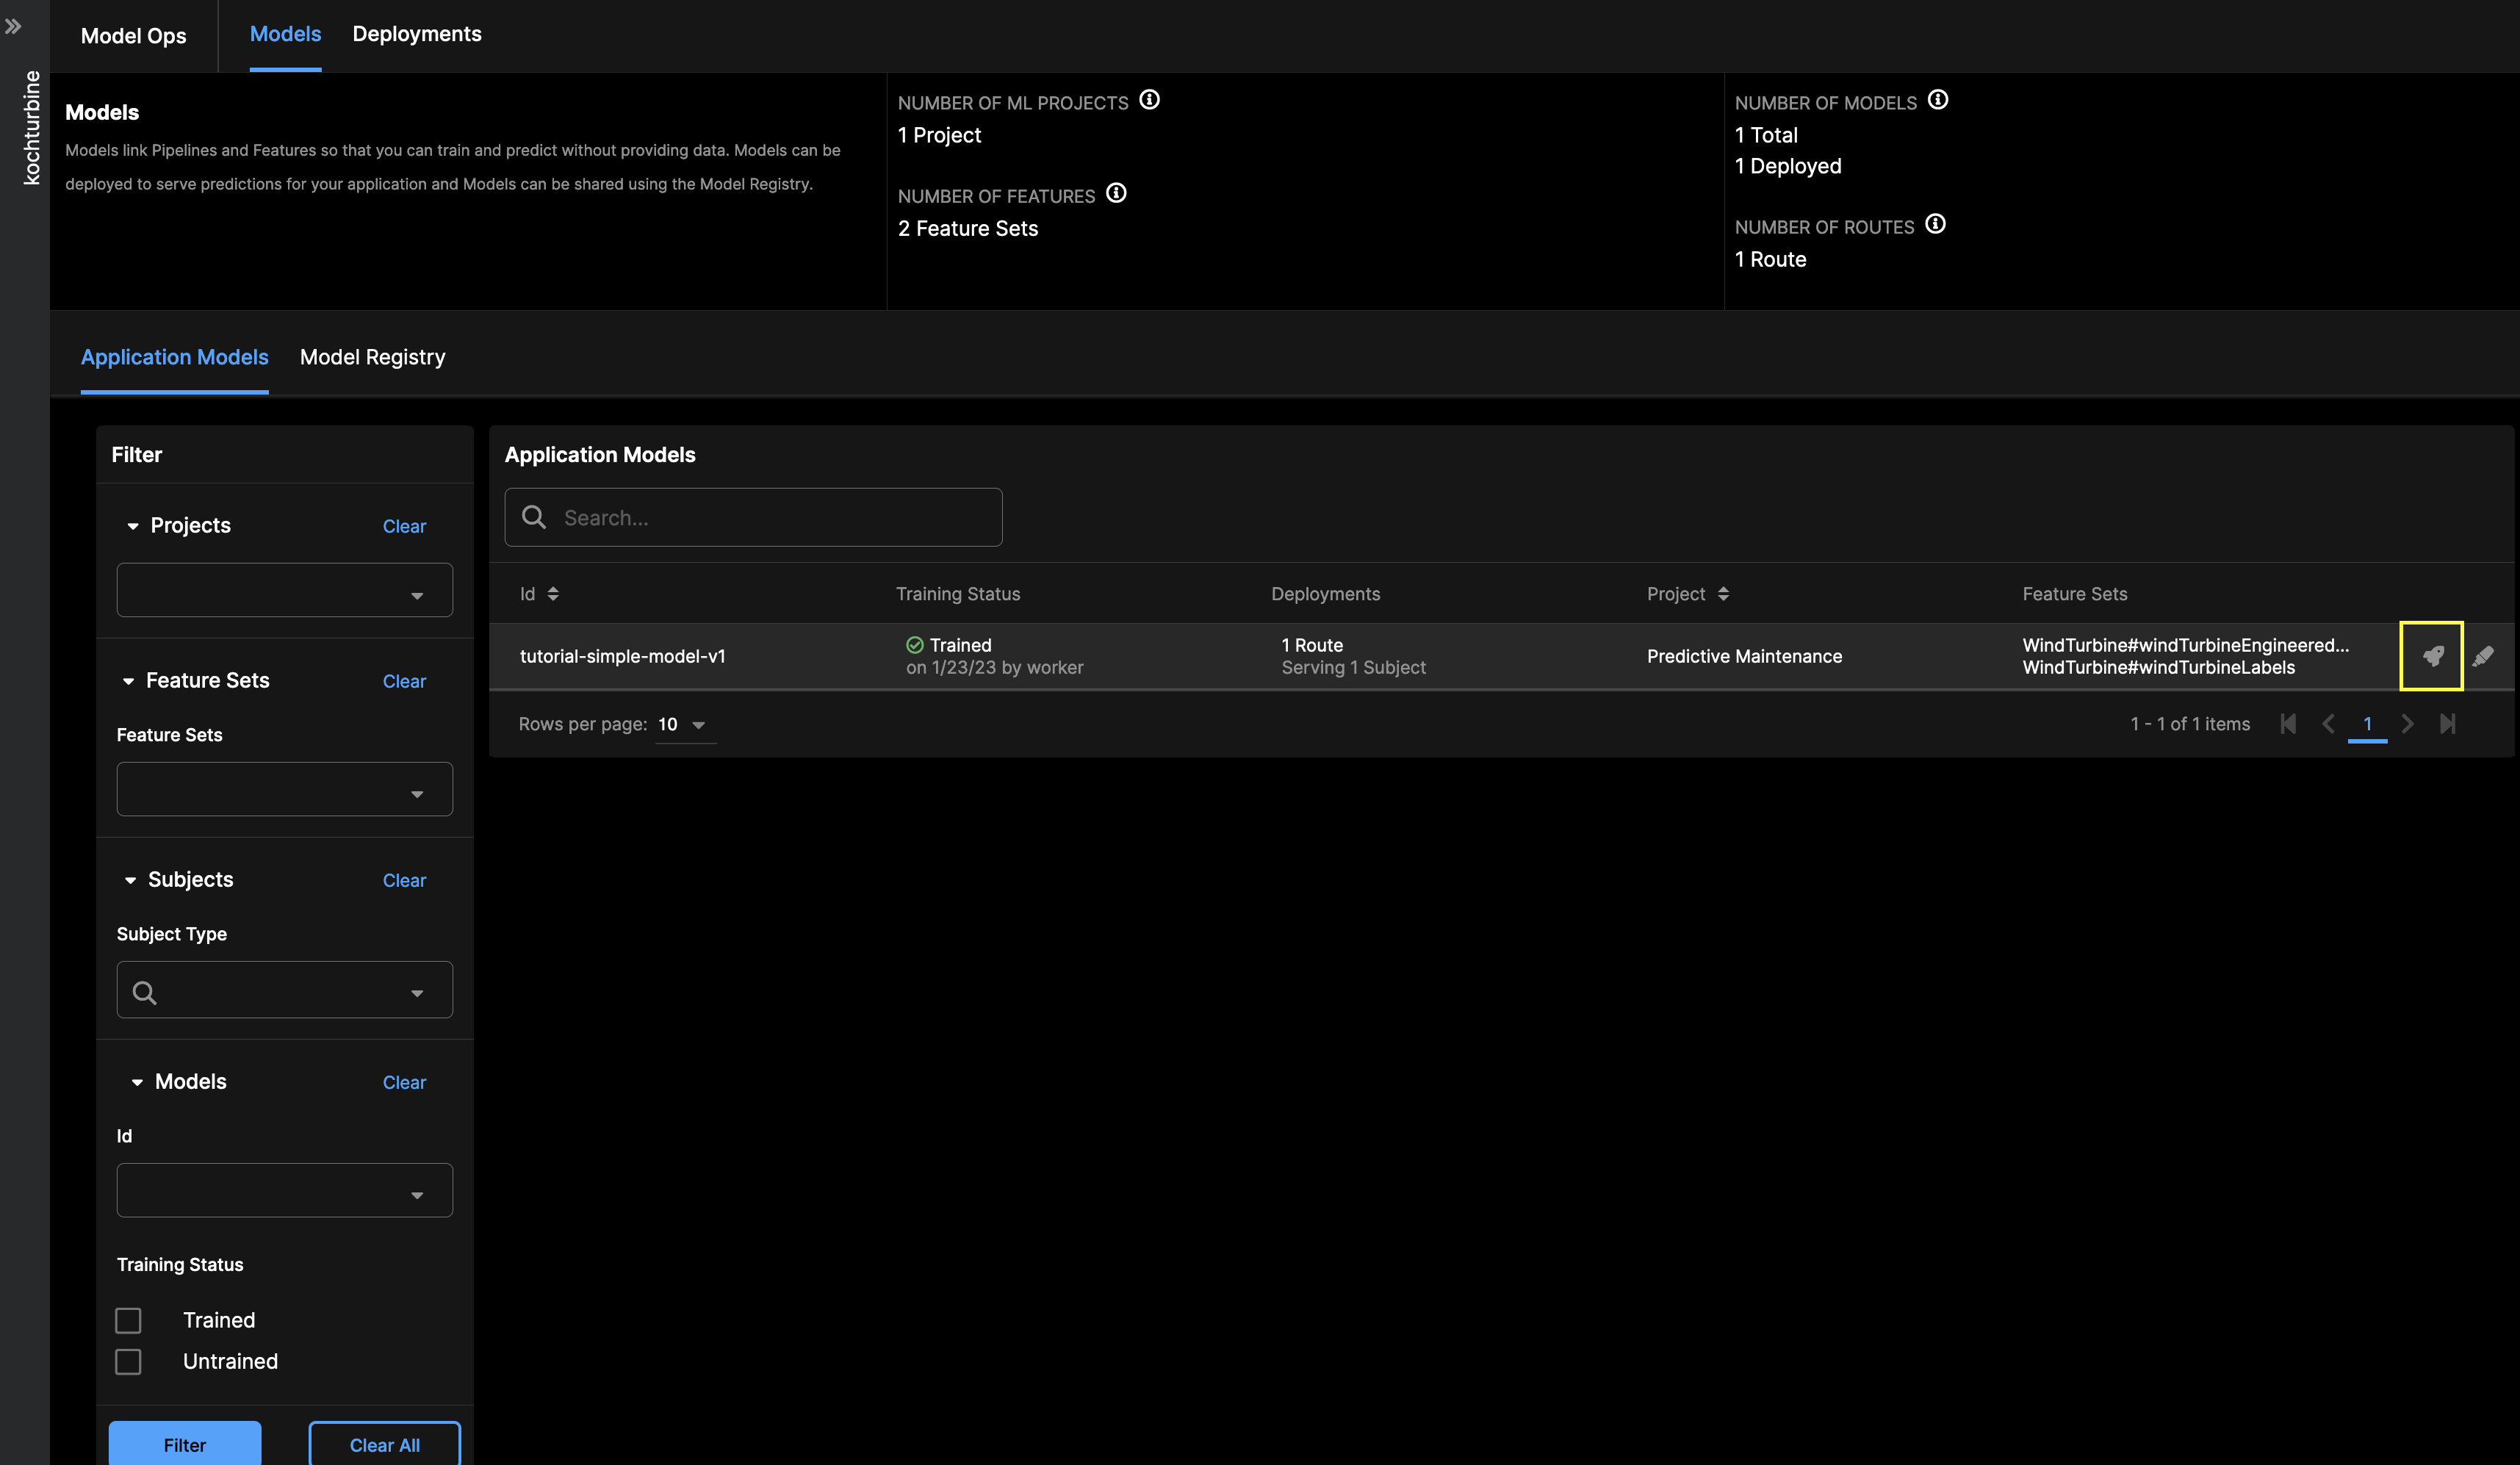

### Update the status of the Model to be `CHAMPION`

In [7]:
route.updateStatus("CHAMPION")

Or update status from AI Studio

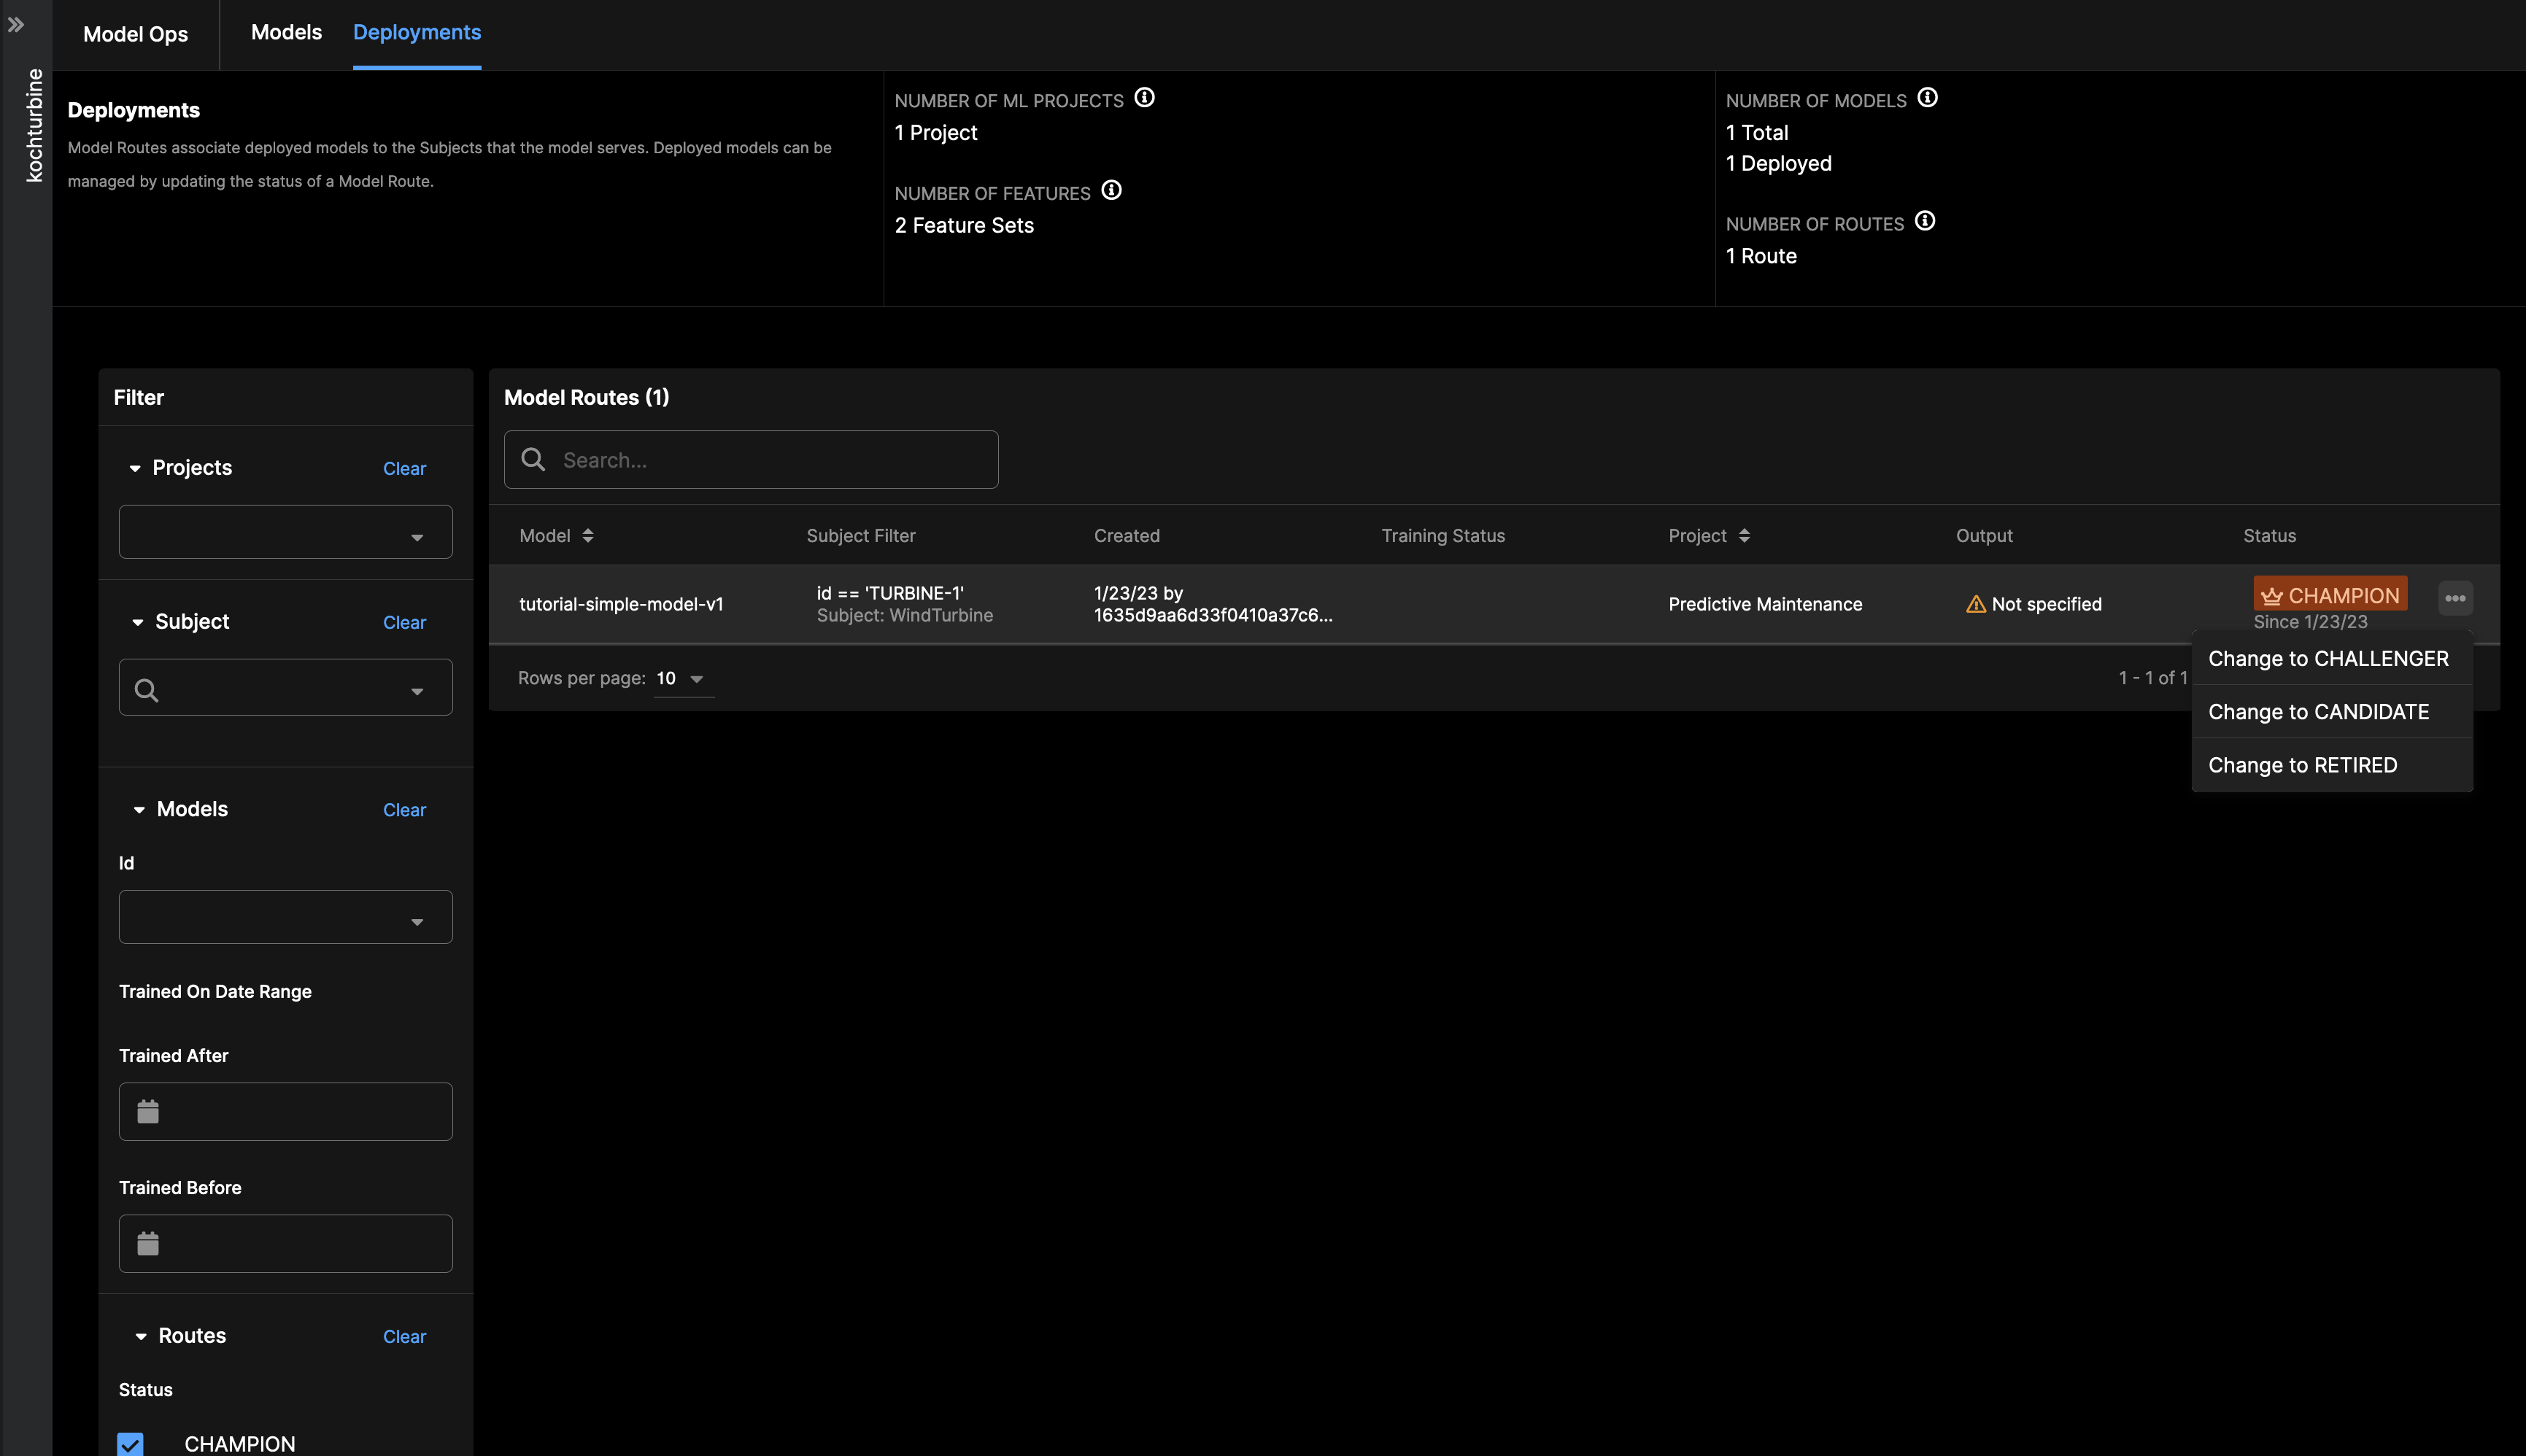

### Generate Predictions for a WindTurbine

In [6]:
wt = c3.WindTurbine.forId('demo_TURBINE-3')
preds = wt.process(start="2022-05-01", end="2022-05-31", project=project).outputs
preds[model.id][0].riskScore

0
subject   timestamp               
TURBINE-1 2012-05-01 00:00:00  0.0
          2012-05-01 01:00:00  0.0
          2012-05-01 02:00:00  0.0
          2012-05-01 03:00:00  0.0
          2012-05-01 04:00:00  0.0
...                            ...
          2012-05-31 19:00:00  0.0
          2012-05-31 20:00:00  0.0
          2012-05-31 21:00:00  0.0
          2012-05-31 22:00:00  0.0
          2012-05-31 23:00:00  0.0

[744 rows x 1 columns]

### Retire the Model

<div class="alert-info">
    <b>Exercise</b>: 
    Retire the `MlModel.Route` that we created after calling `model.deploy`
    <br>
    <br>
    <div><i>Hint</i>: use the `updateStatus` method for the deployment route to set the status to `RETIRED`
    </div>
</div>

In [5]:
# # TODO: Retire the `MlModel.Route` that we just created
# route.##TODO

### Automatically Store Predictions in `WindTurbinePredictions`

We are generating predictions for each `WindTurbine` with deployed models, but the predictions are not yet being persisted. 

At the time of deployment, `MlModel.OutputHandler`(s) can be specified to automatically persist the predictions.

There are several options for persisting outputs from the `MlModel`. Here are two common ones:

1. Write to a Database using the `MlModel.DbOutputHandler`
2. Write to a CSV using the `MlModel.CsvOutputHandler`

#### Create an OutputHandler

Next, we need to map the output of the `MlModel` to the fields of `WindTurbinePrediction`

`MlModel.DbOutputHandler` handler maps the output of prediction output to entity type, and persists the entity type.

By default the field names that are output from `MlSubject#process` are:
 * `modelId` is the ID of the `MlModel`
 * `subject` is the ID of the `MlSubject` for which the output is computed
 * `statusLabel` is the `MlModel.Route.Status.Label` of the `MlModel.Route`
 * `statusTags` is a string representing the (optional) `MlModel.Route.Status#tags` of the route
 * `timestamp` is the timestamp for which the output is computed (optional)
 * `0` field corresponds to the prediction that we map to `WindTurbinePrediction.value`.

In [9]:
dbHandler = c3.MlModel.DbOutputHandler(
    outputNames=["riskScore"],
    targetType = c3.WindTurbinePrediction,
    columnMapping={
        "modelId": "model",
        "statusLabel" : "status",
        "0": "value"        
    },
).withDefaults()

<div class="alert-info">
    <b>Exercise</b>: 
    Deploy the trained `MlModel` with the `MlModel.DbOutputHandler` that was just created
    <br>
    <br>
    <div><i>Hint</i>: the `deploy` method has an `outputHandlers` argument, where you can specify a list of `OutputHandlers`
    </div>
</div>

In [7]:
# # TODO: Deploy the model with the OutputHandler - dbHandler
# route_with_handler = model.deploy(subjectFilter = "location == 'FRANCE'", outputHandlers = ##TODO)

In [ ]:
route_with_handler.updateStatus("CHAMPION")

### Predict and Store Results

In [11]:
process_result = wt.process(start="2022-05-01", end="2022-05-31", project=project)

{
  "type" : "MlSubject.ProcessResult",
  "outputs" : {
    "tutorial-simple-model-v1" : [ {
      "type" : "Boxed<!{ riskScore: Data }>",
      "value" : {
        "type" : "!{ riskScore: Data }",
        "riskScore" : {
          "type" : "Data.Persisted",
          "lazies" : {
            "0" : {
              "type" : "Data.Persisted",
              "this" : {
                "type" : "Feature.Store"
              },
              "action" : "readData",
              "args" : {
                "id" : "285bbe62-9604-4656-ac4d-88105f0e0745",
                "tableName" : "Data_Persisted"
              }
            }
          }
        }
      }
    } ],
    "tutorial-simple-model" : [ {
      "type" : "Boxed<!{ riskScore: Data }>",
      "value" : {
        "type" : "!{ riskScore: Data }",
        "riskScore" : {
          "type" : "Data.Persisted",
          "lazies" : {
            "0" : {
              "type" : "Data.Persisted",
              "this" : {
                "type" :

Now we can eval from WindTurbinePrediction and see that results are automatically stored

In [12]:
c3.WindTurbinePrediction.eval()

id    subject  ...     status value
0    00edf92b-1a90-4f8f-9211-45bf0652ebb5  TURBINE-1  ...  CANDIDATE   0.0
1    01ecd24f-340a-413c-8874-f4a0d11c7dce  TURBINE-1  ...  CANDIDATE   0.0
2    027e9855-7ed0-45ed-816e-97ed86555e61  TURBINE-1  ...  CANDIDATE   1.0
3    0328e597-872a-4cd4-87f3-2e1e67e51f66  TURBINE-1  ...  CANDIDATE   1.0
4    038306a6-1f32-4973-b464-5d4cf1f47e9c  TURBINE-1  ...  CANDIDATE   0.0
..                                    ...        ...  ...        ...   ...
739  fea6674d-c708-4f71-a759-9a18c3bb22ee  TURBINE-1  ...  CANDIDATE   0.0
740  feff6ae3-50cb-4009-9eea-798a8adbf2a6  TURBINE-1  ...  CANDIDATE   0.0
741  ff2a18bb-4a81-4c04-85ac-c0d350b0171c  TURBINE-1  ...  CANDIDATE   0.0
742  ffa73335-94bb-4fde-ab2e-e7819fbb1a31  TURBINE-1  ...  CANDIDATE   1.0
743  ffcc2b3a-16b0-43ea-83e3-480d3e31c65e  TURBINE-1  ...  CANDIDATE   0.0

[744 rows x 6 columns]

#### Register the Model

In [34]:
##TODO choose a path for storing your model in the registry e.g., your_name/windturbine-pm/france
uri = ##TODO

entry = c3.ModelRegistry.registerMlModel(mlModel=model, 
                                      uri=uri, 
                                      desc='Trained on Wind Turbines in France')

Or Register the Model from AI Studio

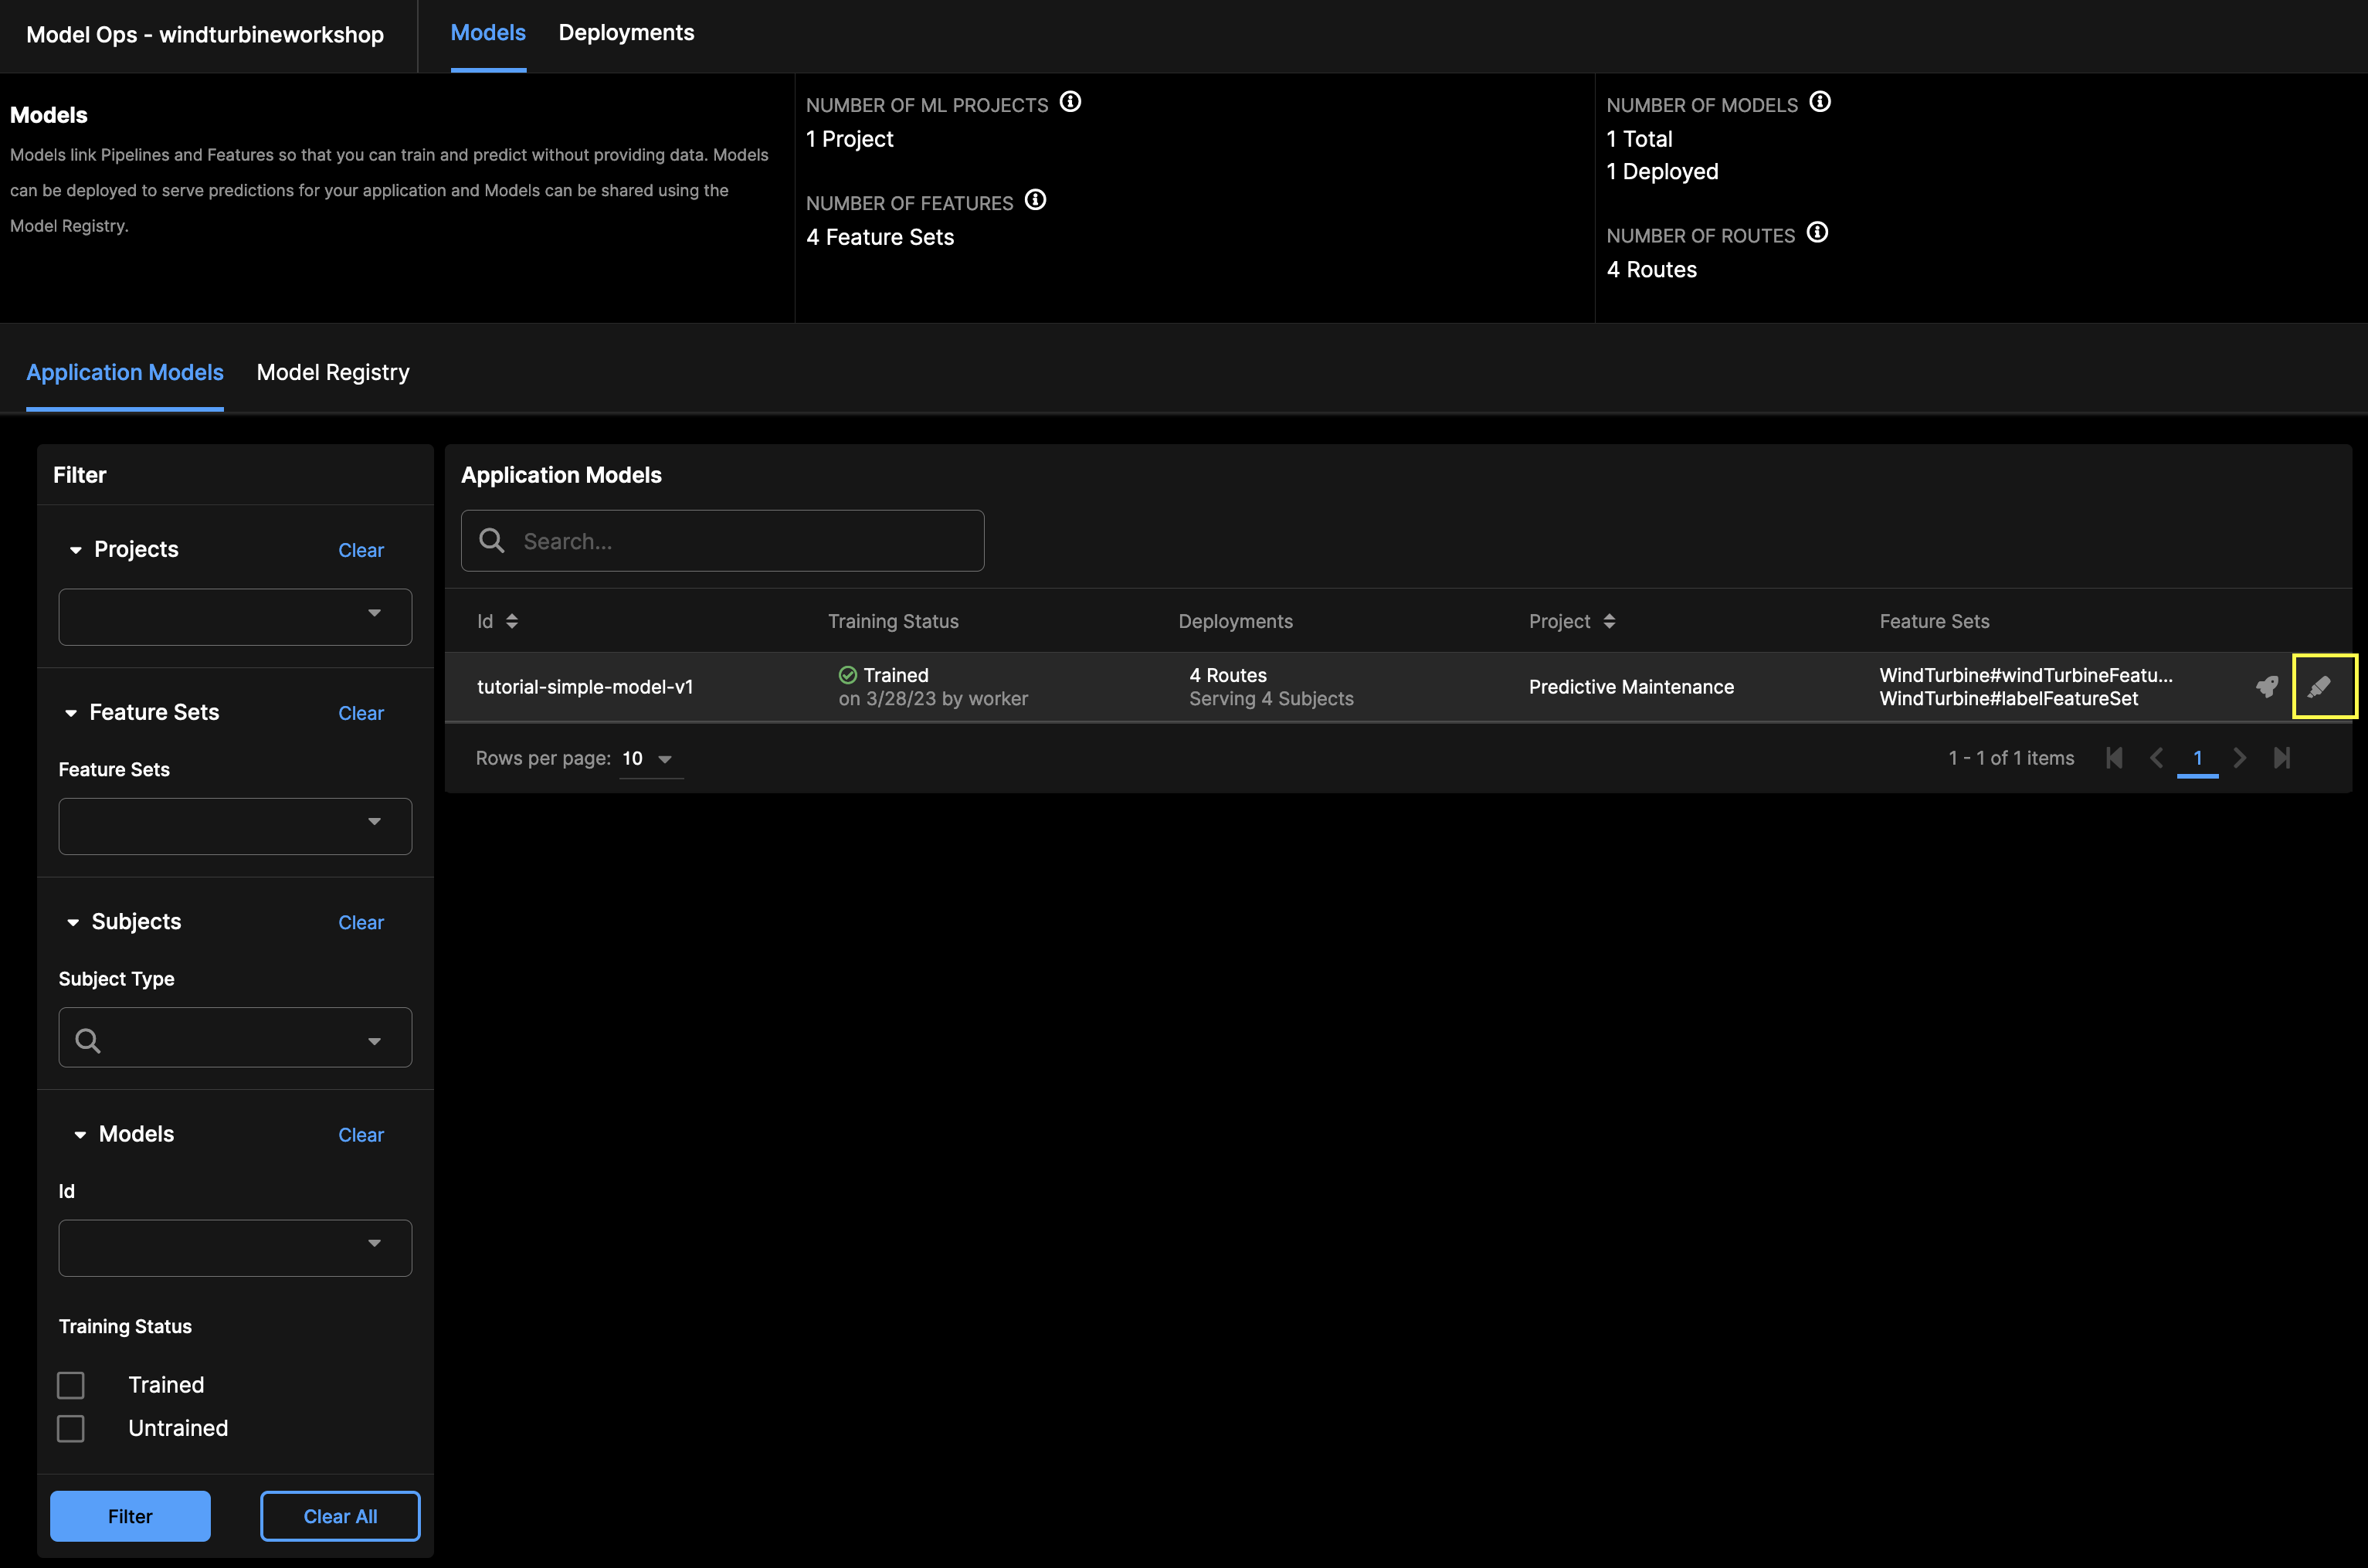

In [35]:
approval_metadata = c3.ModelApproval.Update.Status(modelUri = entry.uri,
                                                   modelVersion = entry.ver,
                                                   scope = "Approval 1",
                                                   status = "Approved")
c3.ModelApproval.update(approval_metadata)

{
  "type" : "ModelApproval.Status",
  "modelUri" : "/windturbine-pm/france-model",
  "modelVersion" : 2,
  "scope" : "Approval 1",
  "status" : "Approved",
  "updatedBy" : "stagegkev8training1-jatest2-windturbineworkshop",
  "updatedAt" : "2023-03-28T20:35:37Z",
  "createdAt" : "2023-03-28T20:35:37Z"
}

#### Load Model from Registry

In [37]:
loaded_model = c3.ModelRegistry.loadMlModel(uri = entry.uri, version = entry.ver)

In [45]:
preds = loaded_model.process(subjectFilter="location=='FRANCE'", start="2022-05-01", end="2022-05-31").result()

In [46]:
preds['riskScore']

0
subject        timestamp               
demo_TURBINE-3 2022-05-01 00:00:00  0.0
               2022-05-01 01:00:00  1.0
               2022-05-01 02:00:00  0.0
               2022-05-01 03:00:00  0.0
               2022-05-01 04:00:00  0.0
...                                 ...
demo_TURBINE-5 2022-05-30 19:00:00  1.0
               2022-05-30 20:00:00  1.0
               2022-05-30 21:00:00  1.0
               2022-05-30 22:00:00  1.0
               2022-05-30 23:00:00  1.0

[1440 rows x 1 columns]